In [12]:
import numpy as np 
import pandas as pd 
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import torch
from torchvision import datasets
import json
import os
import PIL
from torchvision.transforms.functional import to_pil_image
import cv2
from skimage.io import imread,imshow
import random
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df=pd.read_json('/kaggle/input/ra-assignment/human_activity_retrieval_dataset/train_image_info.json',orient='index')
df.reset_index(inplace=True)
df.columns=['id','label']

In [3]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()

df['num_label']=lb.fit_transform(df['label'])
num_classes = 15
device='cuda' if torch.cuda.is_available else 'cpu'
device

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


'cuda'

In [4]:
# model = models.densenet121(pretrained=True)

# model.fc = nn.Linear(model.classifier.in_features, num_classes)

# for params in model.features.denseblock4.denselayer16.parameters():
#     params.requires_grad=True
    
model=torch.load('/kaggle/input/10-epoch/model_10.pth')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [5]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, prefix_path, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.prefix=prefix_path
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        img_path=self.prefix+'/'+img_path
        image = Image.open(img_path).convert("RGB")

        label = self.dataframe.iloc[idx, 2]  
        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

prefix_path='/kaggle/input/ra-assignment/human_activity_retrieval_dataset/train'
custom_dataset = CustomDataset(dataframe=df,prefix_path=prefix_path,transform=transform)
batch_size = 32
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

In [ ]:

num_epochs=10
train_loss_history = []
train_accuracy_history = []

model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(data_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = correct_predictions / total_samples

    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_accuracy)

    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

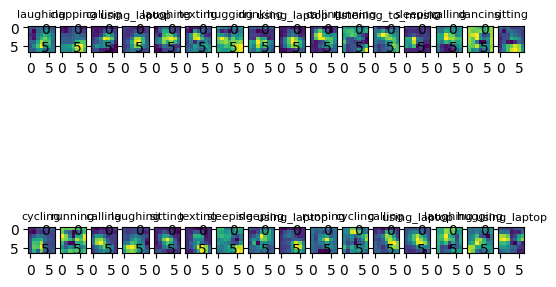

In [9]:

model.to('cpu')

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

handle=model.features.denseblock4.denselayer16.conv2.register_forward_hook(get_features('feats'))

features={}
img,label=next(iter(data_loader))
preds=model(img)
features['feats'].shape

lab_names=lb.inverse_transform(label)
for i,(feat,lab ) in enumerate(zip(features['feats'],lab_names)):
    
    plt.subplot(2,16,i+1)
  
    plt.imshow(feat.cpu().numpy()[0])
    plt.title(lab,fontsize=8)
    
    
handle.remove()

In [10]:
new_handle=model.features.norm5.register_forward_hook(get_features('feats'))

features={}
avg_pool_layer = nn.AdaptiveAvgPool2d((1))
preds=model(img)
outputs=avg_pool_layer(features['feats'])
outputs.shape

torch.Size([32, 1024, 1, 1])

In [ ]:
# new_handle.remove()
# torch.save(model,'/kaggle/working/model_10.pth')

In [13]:
output_feats=[]

labels=[]

model.to('cuda')

features={}
for img_batch,lab_batch in tqdm(data_loader):
    preds=model(img_batch.to('cuda'))
    for feats in features['feats']:
        feats=avg_pool_layer(feats)
        output_feats.append(feats.view(-1).detach().cpu().numpy())
    for lab in lab_batch:
        labels.append(lab.detach().cpu())

100%|██████████| 358/358 [03:34<00:00,  1.67it/s]


In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2) 
reduced_data = tsne.fit_transform(np.array(output_feats))

/tmp/ipykernel_47/779335938.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.get_cmap('turbo')(float(i) / len(lb.classes_)), markersize=10) for i in range(len(lb.classes_))]


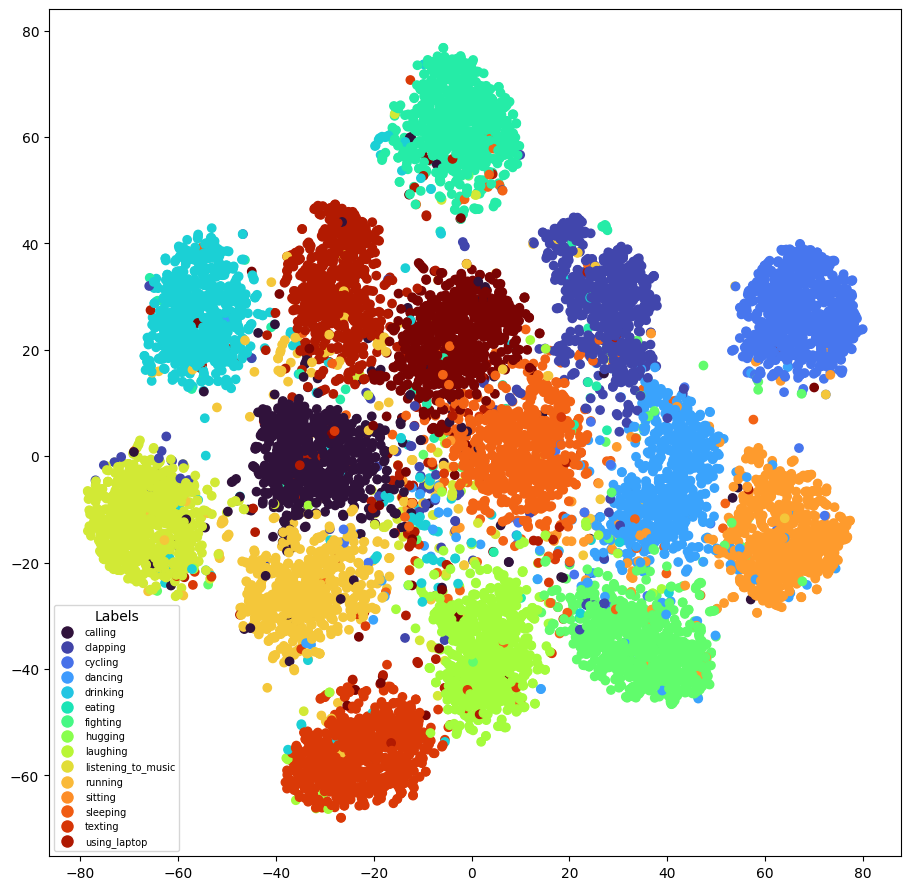

In [15]:


plt.figure(figsize=(11, 11))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='turbo')  
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.get_cmap('turbo')(float(i) / len(lb.classes_)), markersize=10) for i in range(len(lb.classes_))]
labels_legend = [str(label) for label in lb.classes_]
plt.legend(handles, labels_legend, title='Labels', fontsize=7)
plt.show()

In [16]:
test_df=pd.read_json('/kaggle/input/ra-assignment/human_activity_retrieval_dataset/test_image_info.json',orient='index')
test_df.reset_index(inplace=True)
test_df.columns=['id','label']

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    transforms.ToTensor(),
])

test_df['class_label']=''

In [17]:
for paths in os.listdir('/kaggle/input/ra-assignment/human_activity_retrieval_dataset/query_images'):
    ind=test_df.index[test_df['id']==paths].tolist()
    test_df['class_label'][ind]='query'
for paths in os.listdir('/kaggle/input/ra-assignment/human_activity_retrieval_dataset/gallery'):
    ind=test_df.index[test_df['id']==paths].to_list()
    test_df['class_label'][ind]='gallery'

In [18]:
gallery_df=test_df[test_df['class_label']=='gallery']
query_df=test_df[test_df['class_label']=='query']

print(len(gallery_df))
print(gallery_df.isnull().sum())
print(gallery_df['class_label'].value_counts())

print(len(query_df))
print(query_df.isnull().sum())
print(query_df['class_label'].value_counts())

1000
id             0
label          0
class_label    0
dtype: int64
class_label
gallery    1000
Name: count, dtype: int64
150
id             0
label          0
class_label    0
dtype: int64
class_label
query    150
Name: count, dtype: int64


In [19]:
gallery_df['num_label']=lb.transform(gallery_df['label'])
query_df['num_label']=lb.transform(query_df['label'])


column_to_move = 'num_label'
target_position = 2
moved_column = gallery_df.pop(column_to_move)
gallery_df.insert(target_position, column_to_move, moved_column)



column_to_move = 'num_label'
target_position = 2
moved_column = query_df.pop(column_to_move)
query_df.insert(target_position, column_to_move, moved_column)



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/tmp/ipykernel_47/2189774711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gallery_df['num_label']=lb.transform(gallery_df['label'])
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and

In [20]:
prefix_path1='/kaggle/input/ra-assignment/human_activity_retrieval_dataset/gallery'
custom_dataset_gallery = CustomDataset(dataframe=gallery_df,prefix_path=prefix_path1,transform=val_transform)
batch_size = 32
gallery_loader = DataLoader(custom_dataset_gallery, batch_size=batch_size, shuffle=True)


prefix_path2='/kaggle/input/ra-assignment/human_activity_retrieval_dataset/query_images'
custom_dataset_query = CustomDataset(dataframe=query_df,prefix_path=prefix_path2,transform=val_transform)
batch_size = 32
query_loader = DataLoader(custom_dataset_query, batch_size=batch_size, shuffle=True)

In [21]:
gallery_feats=[]

gallery_labels=[]

model.to('cuda')

features={}
for img_batch,lab_batch in tqdm(gallery_loader):
    preds=model(img_batch.to('cuda'))
    for feats in features['feats']:
        feats=avg_pool_layer(feats)
        gallery_feats.append(feats.view(-1).detach().cpu().numpy())
    for lab in lab_batch:
        gallery_labels.append(lab.detach().cpu())

100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


In [23]:
query_feats=[]

query_labels=[]

model.to('cuda')

features={}
for img_batch,lab_batch in tqdm(query_loader):
    preds=model(img_batch.to('cuda'))
    for feats in features['feats']:
        feats=avg_pool_layer(feats)
        query_feats.append(feats.view(-1).detach().cpu().numpy())
    for lab in lab_batch:
        query_labels.append(lab.detach().cpu())

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


In [24]:
query_feats=np.array(query_feats)
gallery_feats=np.array(gallery_feats)


query_labels=np.array(query_labels)
gallery_labels=np.array(gallery_labels)

In [25]:
cosine_similarities = np.dot(query_feats, gallery_feats.T)
query_norms = np.linalg.norm(query_feats, axis=1)
gallery_norms = np.linalg.norm(gallery_feats, axis=1)
cosine_similarities /= np.outer(query_norms, gallery_norms)

In [30]:
def mean_avg_precision(query_labels, gallery_labels, k, cosine_similarities):
    precision_values = []
    rank_values = []

    for i in range(len(query_labels)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        top_k_gallery_labels = gallery_labels[sorted_indices[:k]]

        precision_at_k = np.sum(top_k_gallery_labels == query_labels[i]) / k
        precision_values.append(precision_at_k)

        


    mean_average_precision = np.mean(precision_values)


    print(f"Mean Average Precision at k={k}: {mean_average_precision}")


    
mean_avg_precision(query_labels,gallery_labels,1,cosine_similarities)
mean_avg_precision(query_labels,gallery_labels,10,cosine_similarities)
mean_avg_precision(query_labels,gallery_labels,50,cosine_similarities)

Mean Average Precision at k=1: 0.6533333333333333
Mean Average Precision at k=10: 0.5613333333333334
Mean Average Precision at k=50: 0.43626666666666664


In [34]:
def mean_rank(query_labels,gallery_labels,cosine_similarities):
    rank_values = []

    for i in range(len(query_labels)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
       

      
      
        relevant_rank = np.where(sorted_indices == i)[0][0] + 1  
        rank_values.append(relevant_rank)

   
    mean_rank = np.mean(rank_values)

   
    print(f"Mean Rank: {mean_rank}")
    

mean_rank(query_labels,gallery_labels,cosine_similarities)

Mean Rank: 489.3666666666667


In [27]:
query_data = tsne.fit_transform(np.array(query_feats))
gallery_data = tsne.fit_transform(np.array(gallery_feats))

/tmp/ipykernel_47/1150121341.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.get_cmap('turbo')(float(i) / len(lb.classes_)), markersize=10) for i in range(len(lb.classes_))]
/tmp/ipykernel_47/1150121341.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.get_cmap('turbo')(float(i) / len(lb.classes_)), markersize=10) for i in range(len(lb.classes_))]


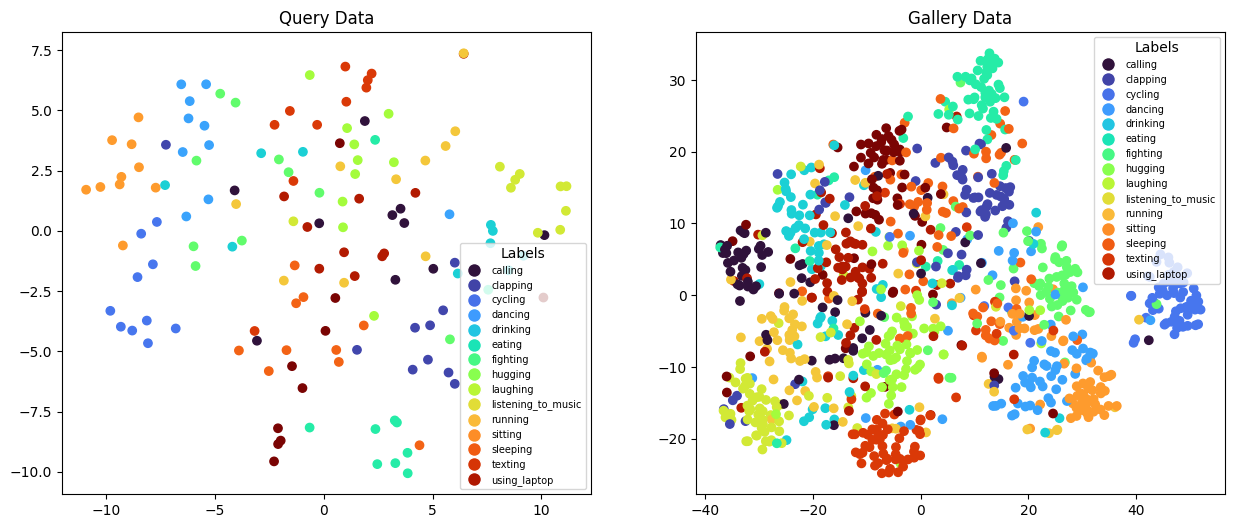

In [28]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(query_data[:, 0], query_data[:, 1], c=query_labels, cmap='turbo')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.get_cmap('turbo')(float(i) / len(lb.classes_)), markersize=10) for i in range(len(lb.classes_))]
labels_legend = [str(label) for label in lb.classes_]
plt.legend(handles, labels_legend, title='Labels', fontsize=7)
plt.title('Query Data')

plt.subplot(1, 2, 2)
plt.scatter(gallery_data[:, 0], gallery_data[:, 1], c=gallery_labels, cmap='turbo')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.get_cmap('turbo')(float(i) / len(lb.classes_)), markersize=10) for i in range(len(lb.classes_))]
labels_legend = [str(label) for label in lb.classes_]
plt.legend(handles, labels_legend, title='Labels', fontsize=7)
plt.title('Gallery Data')

plt.show()